## visualizing results of discrete random variables modeling.

## comparing with the true statistics

read random variables generated by .cpp code and perform visualization and testing

In [1]:
import numpy as np
import pandas as pd
import os
import math
from scipy import stats
from collections import Counter
from matplotlib import pyplot as plt

In [2]:
sz = 1000 # size of sample generated by cpp code
cpp_files_dp = 'cmake-build-debug'

chi_square_95 = {
    1: 3.84, 2: 5.99, 3: 7.82, 4: 9.49, 5: 11.1, 6: 12.6, 7: 14.1, 
    8: 15.5, 9: 16.9, 10: 18.3, 11: 19.7, 12: 21, 13: 22.4, 14: 23.7
}

In [3]:
def read_cpp_sample(path):
    with open(path) as f:
        nums = [int(x) for x in f.readlines()]
    return nums

def get_sample_descriptive_statistics(sample):
    d = {
        'samples_cnt': len(sample),
        'mean': np.mean(sample),
        'variance': np.var(sample, ddof=1),
        'skew': stats.skew(sample, bias=False),
        'kurtosis': stats.kurtosis(sample, bias=False)
    }
    return d

def get_descriptive_table(sample_cpp, sample_python, sample_true=None):
    df = pd.DataFrame(columns=['samples_cnt', 'mean', 'variance', 'skew', 'kurtosis'])
    df.loc['cpp'] = get_sample_descriptive_statistics(sample_cpp)
    df.loc['python'] = get_sample_descriptive_statistics(sample_python)
    if sample_true:
        df.loc['true'] = sample_true
    return df

def get_sample_pmf(sample):
    return np.bincount(sample) / len(sample)

In [4]:
def plot_hist(x, y_true, y_gen):
    plt.xlim(min(x) - 1, max(x) + 1)
    lw = 10
    alpha = 0.5
    for ix, (_x, _y_t, _y_g) in enumerate(zip(x, y_true, y_gen)):
        plt.axvline(_x, ymax=_y_t, color='red', linewidth=lw, alpha=alpha, label='true' if ix == 0 else None)
        plt.axvline(_x, ymax=_y_g, color='blue', linewidth=lw, alpha=alpha, label='generated' if ix == 0 else None)
    plt.legend();
    plt.grid();
    
def chi_squared_test(sample, true_pdf):
    chi_sq = 0
    counter = Counter(sample)
    for k, v in counter.items():
        t = len(sample) * true_pdf[k]
        chi_sq += (v - t) * (v - t) / t
    print('chi squarred: %.3f' % chi_sq)
    degrees_of_freedom = len(counter.items()) - 1
    delta = chi_square_95[degrees_of_freedom]
    print('degrees of freedom: %d, threshold: %.3f' % (degrees_of_freedom, delta))
    print('test passed: %r' % (chi_sq < delta))

In [5]:
def get_binomial_coefficients(n):
    l_prev = [1]
    for i in range(1, n + 1):
        l = l_prev.copy()
        for j in range(1, i):
            l[j] = l_prev[j - 1] + l_prev[j]
        l.append(1)
        l_prev = l.copy()
    return l_prev

def get_binomial_pmf(m, p):
    coef = get_binomial_coefficients(m)
    res = [coef[i] * p ** i * (1 - p) ** (m - i) for i in range(m + 1)]
    return res

def get_geometric_pmf(p, max_n):
    if max_n <= 0:
        raise ValueError("max_n must be > 0")
    # p(x = 0) = 0
    pmf = [0] * (max_n + 1)
    pmf[1] = p
    if max_n == 1: return pmf
    for i in range(2, max_n + 1):
        pmf[i] = pmf[i - 1] * (1 - p)
    return pmf

def get_poisson_pmf(l, max_n):
    if max_n <= 0:
        raise ValueError("max_n must be > 0")
    pmf = [0] * (max_n + 1)
    pmf[0] = math.exp(-l)
    if max_n == 0: return pmf
    for i in range(1, max_n + 1):
        pmf[i] = pmf[i - 1] * l / i
    return pmf

## bernoulli

In [6]:
bernoulli_cpp = read_cpp_sample(os.path.join(cpp_files_dp, 'bernoulli_0.70.txt'))
bernoulli_python = np.random.choice([0, 1], p=[0.3, 0.7], size=sz)
bernoulli_p = 0.7
bernouolli_true = {
    'samples_cnt': np.inf,
    'mean': bernoulli_p,
    'variance': bernoulli_p * (1 - bernoulli_p),
    'skew': (1 - 2 * bernoulli_p) / (bernoulli_p * (1 - bernoulli_p)) ** 0.5,
    'kurtosis': 1 / (bernoulli_p * (1 - bernoulli_p)) - 6
}
get_descriptive_table(bernoulli_cpp, bernoulli_python, bernouolli_true)

,samples_cnt,mean,variance,skew,kurtosis
cpp,1000.000000,0.716,0.203548,-0.959445,-1.081632
python,1000.000000,0.697,0.211402,-0.858639,-1.265273
true,inf,0.700,0.210000,-0.872872,-1.238095


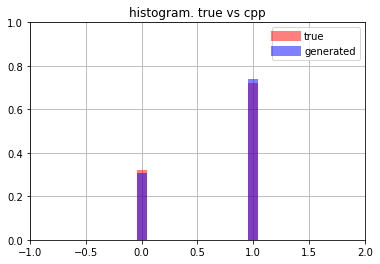

In [7]:
x = [0, 1]
bernoulli_pmf = [1 - bernoulli_p, bernoulli_p]
y_cpp = get_sample_pmf(bernoulli_cpp)
plot_hist(x, bernoulli_pmf, y_cpp)
plt.title('histogram. true vs cpp');

In [8]:
chi_squared_test(bernoulli_cpp, bernoulli_pmf)

chi squarred: 1.219
degrees of freedom: 1, threshold: 3.840
test passed: True


In [9]:
chi_squared_test(bernoulli_python, bernoulli_pmf)

chi squarred: 0.043
degrees of freedom: 1, threshold: 3.840
test passed: True


## binomial

In [10]:
binomial_m = 5
binomial_p = 0.25

binomial_cpp = read_cpp_sample(os.path.join(cpp_files_dp, 'binomial_5_0.25.txt'))
binomial_python = np.random.binomial(binomial_m, binomial_p, size=sz)
binomial_true = {
    'samples_cnt': np.inf,
    'mean': binomial_m * binomial_p,
    'variance': binomial_m * binomial_p * (1 - binomial_p),
    'skew': (1 - 2 * binomial_p) / (binomial_m * binomial_p * (1 - binomial_p)) ** 0.5,
    'kurtosis': 1 / (binomial_m * binomial_p * (1 - binomial_p)) - 6 / binomial_m
}
get_descriptive_table(binomial_cpp, binomial_python, binomial_true)

,samples_cnt,mean,variance,skew,kurtosis
cpp,1000.000000,1.212,0.831888,0.457281,-0.289999
python,1000.000000,1.204,0.953337,0.533007,-0.187082
true,inf,1.250,0.937500,0.516398,-0.133333


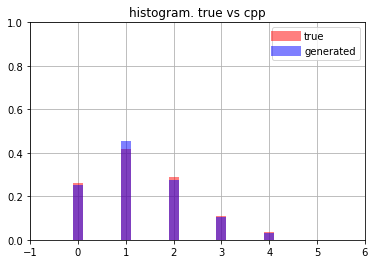

In [11]:
x = np.arange(binomial_m + 1)
binomial_pmf = get_binomial_pmf(binomial_m, binomial_p)
y_cpp = get_sample_pmf(binomial_cpp)
plot_hist(x, binomial_pmf, y_cpp)
plt.title('histogram. true vs cpp');

In [12]:
chi_squared_test(binomial_cpp, binomial_pmf)

chi squarred: 8.689
degrees of freedom: 4, threshold: 9.490
test passed: True


In [13]:
chi_squared_test(binomial_python, binomial_pmf)

chi squarred: 4.345
degrees of freedom: 5, threshold: 11.100
test passed: True


## geometric

In [14]:
geometric_p = 0.7

geometric_cpp = read_cpp_sample(os.path.join(cpp_files_dp, 'geometric_0.70.txt'))
geometric_python = np.random.geometric(geometric_p, size=sz)
geometric_true = {
    'samples_cnt': np.inf,
    'mean': 1 / geometric_p,
    'variance': (1 - geometric_p) / geometric_p / geometric_p,
    'skew': (2 - geometric_p) / (1 - geometric_p) ** 0.5,
    'kurtosis': geometric_p * geometric_p / (1 - geometric_p) + 6
}
get_descriptive_table(geometric_cpp, geometric_python, geometric_true)

,samples_cnt,mean,variance,skew,kurtosis
cpp,1000.000000,1.472000,0.679896,2.284847,6.727431
python,1000.000000,1.477000,0.712183,2.190117,5.552197
true,inf,1.428571,0.612245,2.373464,7.633333


In [15]:
max(geometric_python), max(geometric_cpp)

(6, 7)

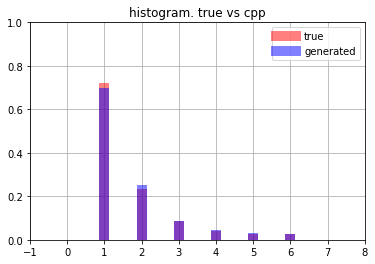

In [16]:
geometric_cpp_max = max(geometric_cpp)
x = np.arange(0, geometric_cpp_max + 1)
geometric_pmf = get_geometric_pmf(geometric_p, geometric_cpp_max)
y_cpp = get_sample_pmf(geometric_cpp)
plot_hist(x, geometric_pmf, y_cpp)
plt.title('histogram. true vs cpp');

In [17]:
chi_squared_test(geometric_cpp, geometric_pmf)

chi squarred: 4.943
degrees of freedom: 6, threshold: 12.600
test passed: True


In [18]:
chi_squared_test(geometric_python, get_geometric_pmf(geometric_p, max(geometric_python)))

chi squarred: 17.370
degrees of freedom: 5, threshold: 11.100
test passed: False


## poisson

In [19]:
poisson_lambda = 2

poisson_cpp = read_cpp_sample(os.path.join(cpp_files_dp, 'poisson_2.txt'))
poisson_python = np.random.poisson(poisson_lambda, size=sz)
poisson_true = {
    'samples_cnt': np.inf,
    'mean': poisson_lambda,
    'variance': poisson_lambda,
    'skew': poisson_lambda ** (-0.5),
    'kurtosis': 1 / poisson_lambda
}
get_descriptive_table(poisson_cpp, poisson_python, poisson_true)

,samples_cnt,mean,variance,skew,kurtosis
cpp,1000.000000,1.975,2.046421,0.829256,0.857503
python,1000.000000,1.995,1.854830,0.733274,0.628061
true,inf,2.000,2.000000,0.707107,0.500000


In [20]:
max(poisson_python), max(poisson_cpp)

(8, 8)

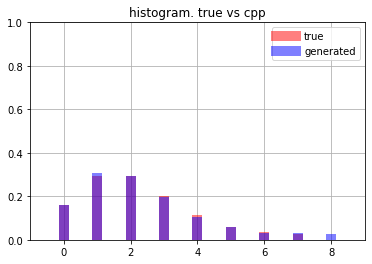

In [21]:
poisson_cpp_max = max(poisson_cpp)
x = np.arange(0, poisson_cpp_max + 1)
poisson_pmf = get_poisson_pmf(poisson_lambda, poisson_cpp_max)
y_cpp = get_sample_pmf(poisson_cpp)
plot_hist(x, poisson_pmf, y_cpp)
plt.title('histogram. true vs cpp');

In [22]:
chi_squared_test(poisson_cpp, poisson_pmf)

chi squarred: 5.348
degrees of freedom: 8, threshold: 15.500
test passed: True


In [23]:
chi_squared_test(poisson_python, get_poisson_pmf(poisson_lambda, max(poisson_python)))

chi squarred: 8.917
degrees of freedom: 8, threshold: 15.500
test passed: True
